# Reduce a hypergraph and compute RBS homology



<span style="color:red">
Important notes: 
</span>

- the strategy is to represent the complex as the Vietoris Rips complex of the adjcency matrix of the complement of the (undirected) graph representing the edge containment poset
- there are more powerful reduction methods than the one shown here.  Enquire for details!

In [1]:
import oatpy as oat

import copy
import plotly.graph_objects as go
import numpy as np
import networkx as nx
import hypernetx as hnx

 No module named 'celluloid'. If you need to use hypernetx.algorithms.contagion, please install additional packages by running the following command: pip install .['all']
 No module named 'igraph'. If you need to use hypernetx.algorithms.hypergraph_modularity, please install additional packages by running the following command: pip install .['all']


# Define a hypergraph

In [2]:
# define a hypergraph

E = { "A": ["x"], "B": ["y"], "C": ["x","y","z","zz"], "D": ["x","y","w","ww"], "DD": ["x","y","w","ww"] }

# Relabel and reduce

Homology calculations are only available for one hypergraphs in one data format: a list of sorted-lists of integers.  **However** we provide tools to translate back and forth between this and other data fromats, e.g. a dictionary of lists of strings.  

Below is one example.  Here we perform two actions in one step: 
- reduce the hypergraph by removing duplicate hyperedges (meaning hyperedges with the same vertex set) and duplicate nodes (meaning nodes that belong to the same set of hyperedges)
- reformat the reduced hypergraph as a list of sorted-lists of integers

In [3]:
# collapse out redundant information, returning a list of lists
reduced_hg, label_translator = oat.hypergraph.reduce_hypergraph_with_labels(E)

# The label_translator object contains the information about what edge 
# (respectively, node) in the original hypergraph maps to which edge
# (respectively, node) in the reduced hypergraph.

# for key in label_translator.keys(): print(key)

print("\n\nReduced hypergraph edges")
print("------------------------")
display(reduced_hg)

print("\n\nNode / edge label translator")
print("----------------------------")
display(label_translator)



Reduced hypergraph edges
------------------------


[[3], [2], [0, 2, 3], [1, 2, 3]]



Node / edge label translator
----------------------------


{'old_node_to_new_node': {'z': 0, 'ww': 1, 'zz': 0, 'w': 1, 'y': 2, 'x': 3},
 'old_edge_to_new_edge': {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'DD': 3},
 'new_node_to_old_nodes': [['z', 'zz'], ['ww', 'w'], ['y'], ['x']],
 'new_edge_to_old_edges': [['A'], ['B'], ['C'], ['D', 'DD']]}

# Plot

### Initial hypergraph

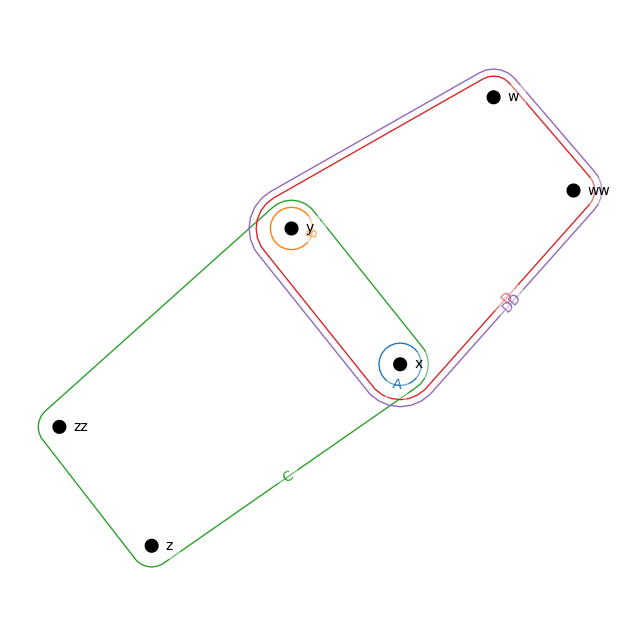

In [4]:
hnxgraph = hnx.Hypergraph(E)
hnx.drawing.draw(hnxgraph)

### Reduced hypergraph

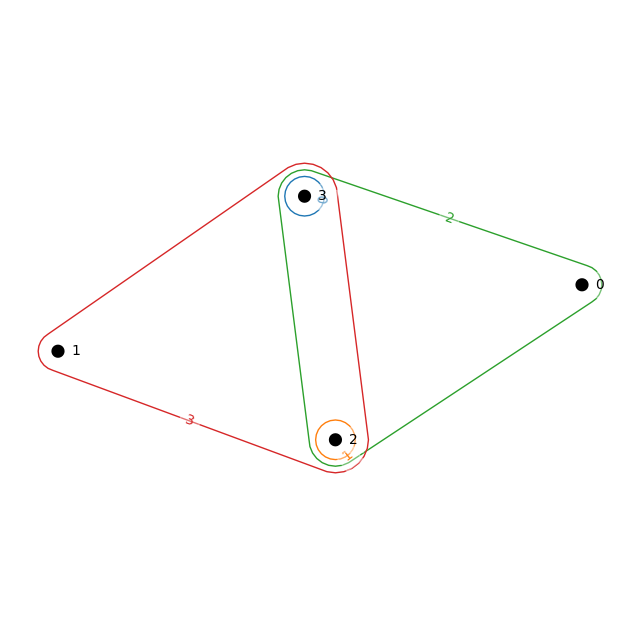

In [5]:
# plot the hypergraph

hnxgraph = hnx.Hypergraph(reduced_hg)
hnx.drawing.draw(hnxgraph)

### Reduced hypergraph, with original labels

Note that we have to
- label each node/vertex with a whole *set* of the old labels, since many nodes/edges in the original hypergraph can map to the the same node/edge of the reduced hypergraph
- here we converted each set of old labels to a string, to make it hashable; it's possible you can sidestep this step in HNX by using a different constructor

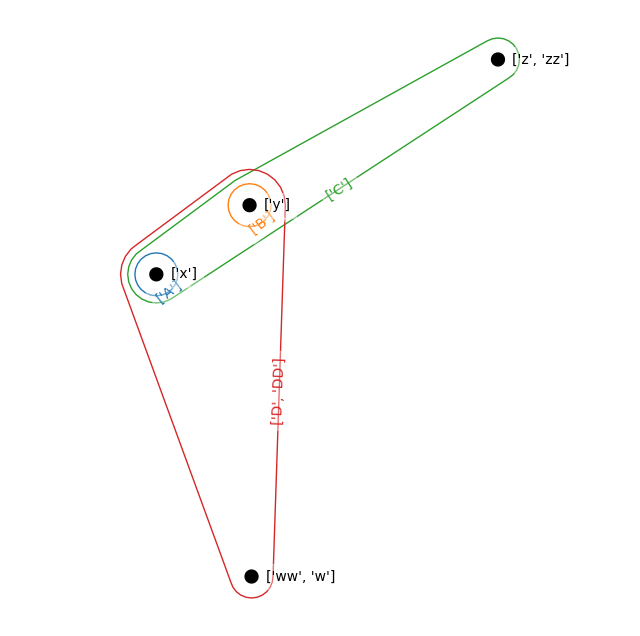

In [6]:
remap_edge              =   lambda x: str(label_translator["new_edge_to_old_edges"][x])
remap_node              =   lambda x: str(label_translator["new_node_to_old_nodes"][x])
reduced_hg_relabeled    =   { remap_edge(edge_label): [ remap_node(n) for n in edge_nodes ] \
                                for edge_label, edge_nodes in enumerate(reduced_hg) }
hnxgraph                =   hnx.Hypergraph(reduced_hg_relabeled)
hnx.drawing.draw(hnxgraph)

# Compute homology

In [7]:
# graph representing the edge containment poset (forgetting direction)
containment                 =   oat.hypergraph.edge_containment_graph_symmetrized( reduced_hg )
# graph whose edges form the set complement of the containment graph
anticontainment             =   nx.complement( containment )
# adjacency matrix of the anticontainment graph
anti_adjacency              =   nx.adjacency_matrix( anticontainment ).todense()
dissimilarity_matrtix       =   oat.dissimilarity.matrix_from_dense(
                                    dissimilarity_matrix    =   anti_adjacency,
                                    dissimilarity_max       =   0.5
                                )

# factored boundary matrix
factored                    =   oat.rust.FactoredBoundaryMatrixVr(
                                    dissimilarity_matrix    =   dissimilarity_matrtix,
                                    homology_dimension_max  =   1, 
                                )

/var/folders/4h/b3bdnjj95hd6h_xjgdm31vdh0000gn/T/ipykernel_18709/2713563397.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  anti_adjacency              =   nx.adjacency_matrix( anticontainment ).todense()


In [8]:
homology        =   factored.homology()
display(homology)

dimension  birth  death birth simplex death simplex   
id                                                        
0           0    0.0    inf           [0]          None  \
1           1    0.0    inf        [1, 3]          None   

                                 cycle representative  cycle nnz   
id                                                                 
0     simplex  filtration coefficient
0     [0]   ...          1  \
1     simplex  filtration coefficient
0  [1, 3]   ...          4   

   bounding chain bounding nnz  
id                              
0            None         None  
1            None         None

# Inspect a cycle representative

In [9]:
cycle           =   homology["cycle representative"][1]
display(cycle)

simplex  filtration coefficient
0  [1, 3]         0.0           1
1  [1, 2]         0.0          -1
2  [0, 3]         0.0          -1
3  [0, 2]         0.0           1

### Relabel each vertex with an edge

Recall that each vertex in RBS homology represents an edge in the reduced hypergraph (which corresponds to a set of hyperedges in the initial hypergraph).  Here we relabel each vertex with **one** of the edges that maps to it.

In [10]:

remap = { p: l[0] for p,l in enumerate(label_translator["new_edge_to_old_edges"]) }

cycle               =   copy.deepcopy(homology["cycle representative"][1])
cycle["simplex"]    =   [ [remap[x] for x in simplex] for simplex in cycle["simplex"] ]

cycle

simplex  filtration coefficient
0  [B, D]         0.0           1
1  [B, C]         0.0          -1
2  [A, D]         0.0          -1
3  [A, C]         0.0           1

### Relable each vertex with a **set** of edges

Recall that each vertex in RBS homology represents an edge in the reduced hypergraph (which corresponds to a set of hyperedges in the initial hypergraph).

In [11]:
remap               =   label_translator["new_edge_to_old_edges"]

cycle               =   copy.deepcopy(homology["cycle representative"][1])
cycle["simplex"]    =   [ [remap[x] for x in simplex] for simplex in cycle["simplex"] ]
cycle


simplex  filtration coefficient
0  [[B], [D, DD]]         0.0           1
1      [[B], [C]]         0.0          -1
2  [[A], [D, DD]]         0.0          -1
3      [[A], [C]]         0.0           1

# Plot a cycle representative

In [12]:
edges   =   homology["cycle representative"][1]["simplex"]
coo     =   oat.plot.hop_mds_from_simplices( edges.tolist() )

display(edges)
display(coo)

/Users/roek189/anaconda3/envs/oat/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


0    [1, 3]
1    [1, 2]
2    [0, 3]
3    [0, 2]
Name: simplex, dtype: object

{1: array([-0.01180873,  0.27083126, -0.8090856 ]),
 3: array([0.45294808, 0.69364101, 0.20788432]),
 2: array([-0.45280449, -0.69119461, -0.20834596]),
 0: array([ 0.01166514, -0.27327766,  0.80954724])}

In [13]:

remap               =   label_translator["new_edge_to_old_edges"]

data    =   []
for edge in edges:
    trace   =   oat.plot.edge__trace3d( edge=edge, coo=coo )
    label   =   "Simplex " + str( [ remap[x] for x in edge] )
    trace.update( name=label, text=label )
    data.append(trace)

fig = go.Figure(data)
fig.update_layout(title="Hover the cursor to show the label of each simplex!")
fig.show()

